In [52]:
import os,sys
cwd=os.getcwd()
sys.path.append(cwd)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import run_test_packing
from run_test_packing import *
seed=0
xmax,xmin=1,0
ymax,ymin=1,0
zmax,zmin=4,0
ndimensions=3
radii_dist='lognormal'
radius_mu=1.
radius_sig2=0.25
tol_self_collision=1e-2
increment_print=int(1e2)
nsamples=int(1e3 * 2) #expect: far fewer used (until we achieve target porosity within tolerance)

percentilemin,percentilemax=5,95

target_porosity=0.4

def porosity_from_radii(radii_scaled, domain_volume,ndimensions = 3):
    pvolumes = radii_scaled**3 * 4 * np.pi / 3 if ndimensions==3 else radii_scaled**2 * np.pi 
    porosity = (domain_volume - pvolumes.sum()) / domain_volume
    return porosity,pvolumes

def compute_current_domain_bounding_box(radii_scaled,pts,xmax,ymax,zmax,xmin,ymin,zmin):
    radii_scaled.max()
    idmax = pts.argmax(axis=0)
    idmin = pts.argmin(axis=0)

#     bbox_vertices = np.vstack(
#         (pts.min(axis=0) + radii_scaled[idmin],
#         pts.max(axis=0) + radii_scaled[idmax] ))
#     bbox_vertices = np.vstack(
#         (pts.min(axis=0) ,
#         pts.max(axis=0) ))
#     print(pts.min(axis=0), pts.max(axis=0))

#     domain_volume = np.prod( bbox_vertices[1] - bbox_vertices[0] )
#     print(domain_volume)
    domain_volume= (xmax-xmin) * (ymax-ymin) * (zmax-zmin)
    porosity,pvolumes = porosity_from_radii(radii_scaled, domain_volume)
    return bbox_vertices, domain_volume, porosity,pvolumes

def compute_correction(x,r,ineighbors,pts,radii_scaled):
#     print("COMPUTE CORRECTION")
    xn = pts
    rn = radii_scaled

    dxn = (xn - x[None,:]) 
    dn = np.linalg.norm( dxn , 2 , axis=1)
    
#     print(dxn)
    correct = (r+ rn)
    correct = correct[:,None] - dxn / dn[:,None]
#     correct = correct #* dn[:,None]
    x += correct.sum(axis=0)
#     for c in correct:
# #         print(x,c,x+c)
#         x += c
    
    assert( np.isnan(pts).sum()+np.isinf(pts).sum() < 1)
#         print("NAN OR INF COORDINATES")
    return x

def overlap_correction(i, x, r, pts, radii_scaled, registered, pnorm=2):
#     pts = allpts[registered]
#     radii_scaled=allradii_scaled[registered]
#     search_radius = search_radius_factor_of_max_diameter * dmax
#     print(pts.shape)
    if(pts.shape[0]<2):
        return x, 0
#     print(x[None,:] - pts)
    dist_collide = np.linalg.norm(x[None,:] - pts, pnorm, axis=1)
#     print("\n dist_collide ", dist_collide)
    my_collision_length = radii_scaled + r
    icollide = (dist_collide < my_collision_length)
    icollidesum = (icollide).sum()
        
    if( icollidesum < 1 ):
        reinit_flag = 0

    else:
        icollide = np.where(icollide)
        icollide = np.delete(icollide, np.where( dist_collide < tol_self_collision))
        x = compute_correction(x,r,icollide,pts,radii_scaled)
        reinit_flag=0

    return x, reinit_flag

'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''

coord_min,coord_max,coord_minmax=np.min((xmin,ymin,zmin)), np.max((xmax,ymax,zmax)),np.min((xmax,ymax,zmax))
RandomState = np.random.RandomState(0)
print(radius_mu)
lognormal_sig2 = np.log( radius_sig2 / radius_mu**2 + 1 )
lognormal_mu = np.log( radius_mu ) - lognormal_sig2 / 2
radii = RandomState.lognormal( lognormal_mu, lognormal_sig2 ,nsamples)
radii.mean(),np.std(radii)

'''truncate sampled distribution'''
pmin = np.percentile(radii,percentilemin),
pmax = np.percentile(radii,percentilemax)
radii = radii[radii<pmax]
radii = radii[radii>pmin]
nsamplesclip = nsamples - radii.shape[0]
nsamples = radii.shape[0]# - nsamplesclip
radii = np.sort(radii)

'''rescale radii to obtain desired porosity'''
rscale = ( (  np.sum(4*np.pi*(1/3.) * radii**3) ) / ( domain_volume * (1-target_porosity) ) )**(1/3)
Z = radii/rscale
radius_mu_scaled = radius_mu / rscale
radius_sig2_scaled = radius_sig2 / rscale**2
rmax = ( radii_scaled ).max()
dmax = 2*rmax

    
# approx_samples_per_dim = int((nsamples)**(2/3))
# print(approx_samples_per_dim)
# bbox_rescale_factor = 2*Z.max() * approx_samples_per_dim
# xmax *= bbox_rescale_factor
# ymax *= bbox_rescale_factor
# zmax *= bbox_rescale_factor

''' Detect Collisions and Translate Spheres '''
registered = []
unregistered = [i for i in range(nsamples)]
boundary = []
t_list = []
tlast = time.time()
radii_scaled = np.array([])
pts=np.array([])
for i,radius in enumerate(Z):
    
    r = radius
    pt = RandomState.uniform(0,1,[ndimensions])
    pt[0] = (pt[0] ) * (xmax-xmin) + xmin
    pt[1] = (pt[1] ) * (ymax-ymin) + ymin
    pt[2] = (pt[2] ) * (zmax-zmin) + zmin
    x = pt.copy()
    
    if(i==0):
#         registered.append(i)
        pts = np.array([x.tolist()])
        radii_scaled = np.array([radius])
#         print(pts.shape, radii_scaled.shape)
        
    if(i>0 and i%increment_print==0):
#         print(pts.shape, radii_scaled.shape, len(registered))

#         try:
        bbox_vertices, domain_volume, current_porosity, pvolumes = compute_current_domain_bounding_box(radii_scaled, pts, xmax,ymax,zmax,xmin,ymin,zmin)
        print("\n Iteration",i,"\n Curr. Sph. Posn. ",x, "\n Sph. Rad.",r, 
              "\n time", time.time(), "\n current porosity" , current_porosity,
              "\n bbox_vertices", bbox_vertices, "\n domain_volume" , domain_volume)
#         except Exception as e:
#             print(e)
    else:
        x,reinit_flag = overlap_correction(i, x, r, pts, radii_scaled,registered)
        if(reinit_flag==1):
            if(periodic_geometry==1):
                break;
                
        elif(reinit_flag==0):             
            
#             print(Z[i], r)
            registered.append(i)

            pts = np.vstack((pts,x))
            radii_scaled = np.hstack((radii_scaled,r))
            Z[i] = r
            try:
                unregistered.remove(i)
            except Exception as e:
                break;
    t_list.append(time.time() - tlast)
    tlast = time.time()
    

registered=np.array(registered)
domain_volume=xmax*ymax*zmax
bbox_vertices, domain_volume, porosity, pvolumes = compute_current_domain_bounding_box(radii_scaled, pts, xmax,ymax,zmax,xmin,ymin,zmin)
save_filename = 'packing'
#save packing output
idx_points = np.arange(0,len(registered)+1)






print("\n domain size ", " [xmin,xmax] ", xmin,xmax, " [ymin,ymax] ", ymin,ymax, " [zmin,zmax] ", zmin,zmax, " volume " , domain_volume)
print('particle volumes: sum, mean, median, min, max', pvolumes.sum(), pvolumes.mean(), np.median(pvolumes) , pvolumes.min(), pvolumes.max())
print("\n \n \n porosity ", porosity)
print("\n number of spheres ", registered.shape)
print("\n number of registered spheres ", registered.shape)
print("\n number of unregistered spheres ", registered.shape )
print("\n sphere distribution parameters ", radius_mu, radius_sig2)
print("\n mean coordination number ", )
print("\n \n \n ")

stacked_data = np.vstack((idx_points.astype(int), pts[:,0], pts[:,1], pts[:,2], radii_scaled[:])).T
np.savetxt(save_filename + ".txt", stacked_data, header="ID x y z r", fmt='%i,%E,%E,%E,%E')
'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''


1.0

 Iteration 100 
 Curr. Sph. Posn.  [0.7354838  0.12359375 2.30430706] 
 Sph. Rad. 0.049312739793010235 
 time 1541605500.2763925 
 current porosity 0.988631287193687 
 bbox_vertices [[4.99292395e-01 9.86566903e-01 2.74940873e+00]
 [5.11797725e+11 5.11797725e+11 5.11797725e+11]] 
 domain_volume 4

 Iteration 200 
 Curr. Sph. Posn.  [0.07923703 0.01817302 1.41038446] 
 Sph. Rad. 0.052344567078066256 
 time 1541605500.2896457 
 current porosity 0.9749214642852952 
 bbox_vertices [[4.99292395e-01 9.86566903e-01 2.74940873e+00]
 [5.11797725e+11 5.11797725e+11 5.11797725e+11]] 
 domain_volume 4

 Iteration 300 
 Curr. Sph. Posn.  [0.37769082 0.20308717 2.87829899] 
 Sph. Rad. 0.05439435865998484 
 time 1541605500.3053901 
 current porosity 0.959169048892804 
 bbox_vertices [[4.99292395e-01 9.86566903e-01 2.74940873e+00]
 [5.11797725e+11 5.11797725e+11 5.11797725e+11]] 
 domain_volume 4

 Iteration 400 
 Curr. Sph. Posn.  [0.60740656 0.21581337 3.44590481] 
 Sph. Rad. 0.05630639168676919

/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.



 Iteration 1700 
 Curr. Sph. Posn.  [0.42632329 0.75946386 0.60460191] 
 Sph. Rad. 0.08740723431469517 
 time 1541605500.703878 
 current porosity 0.48257642296708736 
 bbox_vertices [[4.99292395e-01 9.86566903e-01 2.74940873e+00]
 [5.11797725e+11 5.11797725e+11 5.11797725e+11]] 
 domain_volume 4

 domain size   [xmin,xmax]  0 1  [ymin,ymax]  0 1  [zmin,zmax]  0 4  volume  4
particle volumes: sum, mean, median, min, max 2.3782564482042967 0.0013331033902490453 0.0011697382288519595 0.0003999999840872293 0.003588599251942969

 
 
 porosity  0.4054358879489258

 number of spheres  (1783,)

 number of registered spheres  (1783,)

 number of unregistered spheres  (1783,)

 sphere distribution parameters  1.0 0.25

 mean coordination number 

 
 
 


'\n--------------------------------------------------------------------------------------------------------\n--------------------------------------------------------------------------------------------------------\n--------------------------------------------------------------------------------------------------------\n'

In [53]:

import numpy as np

idx,x,y,z,r = np.loadtxt("packing.txt",delimiter=",",skiprows=1,unpack=True)

# Check Porosity
volume = 0.
for i in range(0,len(idx)):
	volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
print(1.-volume)


# Check Distribution Parameters
print(np.mean(r))
print(np.std(r))

#Check Overlap
count = 0 
for i in range(0,len(idx)):
    add_to_count=0;
    for j in range(i+1,len(idx)):
        distance = np.sqrt( (x[i]-x[j])*(x[i]-x[j]) + (y[i]-y[j])*(y[i]-y[j]) + (z[i]-z[j])*(z[i]-z[j]) )
        if (distance < (r[i]+r[j])):
            add_to_count=1
    count  = count + add_to_count; 
    
print("Total Number of Overlaps ", count-1)

# Check Porosity
volume = 0.
for i in range(0,len(idx)):
	volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
print(1.-volume)


# Check Distribution Parameters
print(np.mean(r))
print(np.std(r))

#Check Overlap
count = 0 
for i in range(0,len(idx)):
    add_to_count=0;
    for j in range(i+1,len(idx)):
        distance = np.sqrt( (x[i]-x[j])*(x[i]-x[j]) + (y[i]-y[j])*(y[i]-y[j]) + (z[i]-z[j])*(z[i]-z[j]) )
        if (distance < (r[i]+r[j])):
            add_to_count=1
    count  = count + add_to_count; 
    
print("Total Number of Overlaps ", count-1)

-1.3782564460089404
0.06628909987668162
0.01152613034229088
Total Number of Overlaps  0
-1.3782564460089404
0.06628909987668162
0.01152613034229088
Total Number of Overlaps  0


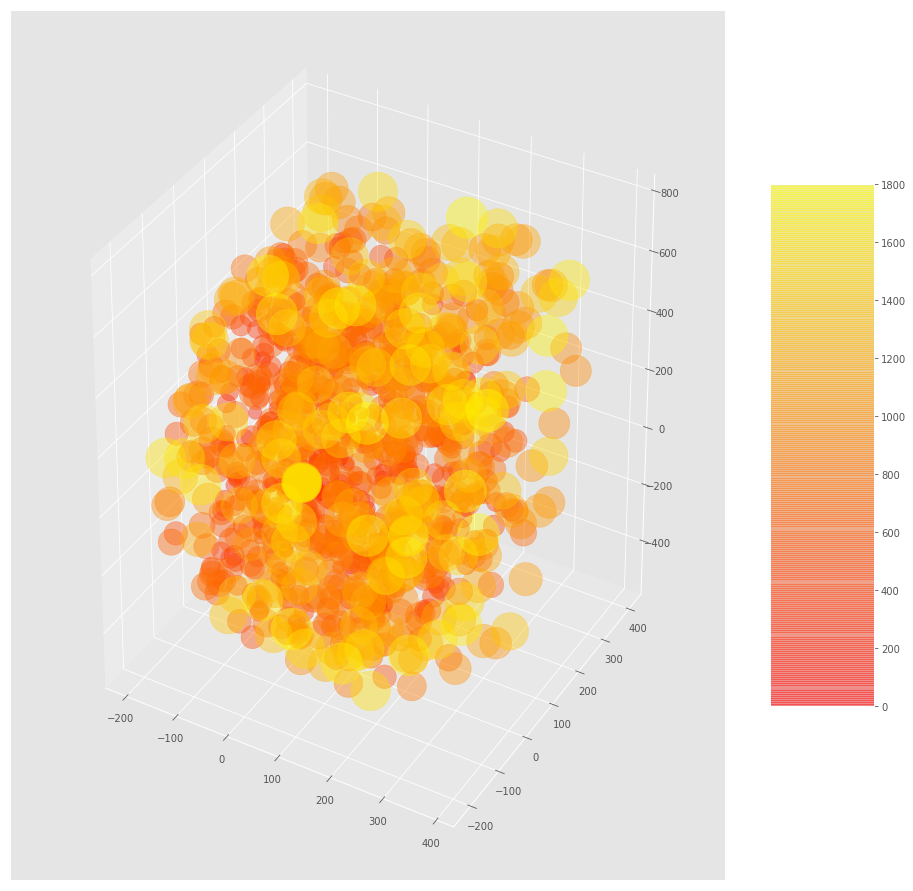

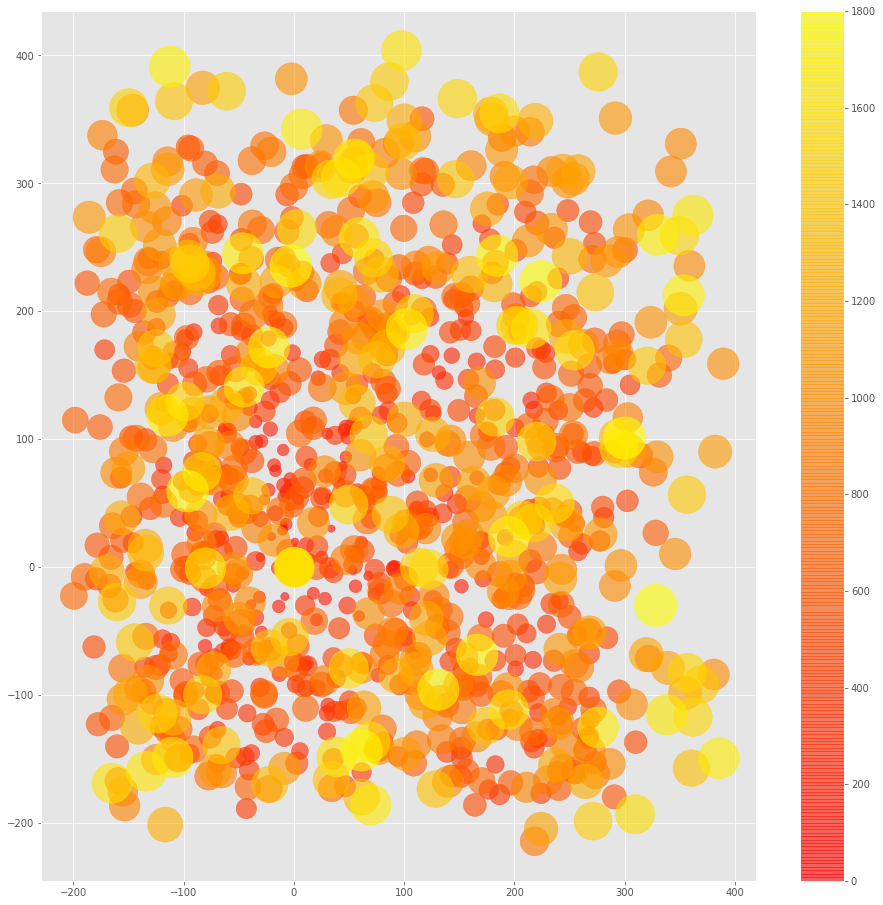

In [54]:
psize = ((pvolumes-pvolumes.min()))
psize = psize/psize.max()
psize = psize * nsamples



fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
X,Y,Z = pts[:,0],pts[:,1],pts[:,2]
cube = ax.scatter(X, Y, Z, zdir='z', s=psize, c=psize,alpha=0.4)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)
plt.savefig(save_filename+'_3d.png',dpi=200)
# plt.show()



# len(),nsamples
plt.figure(figsize=(16,16))
plt.scatter(pts[:,0],pts[:,1],s=psize,c=psize,alpha=0.6)
plt.colorbar()
plt.savefig(save_filename+'_.png',dpi=200)